### Geo data
The column for federal entities' abbreviation is transformed to match the column "ENTIDAD_UM" in the COVID-19 data frame . 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import seaborn as sns
from os import listdir
import geopandas as gpd
import datetime as dt
from datetime import date

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing

sns.set()
%matplotlib inline

In [4]:
path = "Data/"
#covid_general = file_folder(path)

In [5]:
df_geo_states = gpd.read_file(path + "mexstates.shp")

In [6]:
df_geo_states['FIPS_ADMIN'] = df_geo_states['FIPS_ADMIN'].str.replace("MX0","")
df_geo_states['FIPS_ADMIN'] = df_geo_states['FIPS_ADMIN'].str.replace("MX","")
df_geo_states['FIPS_ADMIN'] = df_geo_states['FIPS_ADMIN'].astype(int)

In [7]:
df_geo_states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    32 non-null     int64   
 1   FIPS_ADMIN  32 non-null     int64   
 2   GMI_ADMIN   32 non-null     object  
 3   ADMIN_NAME  32 non-null     object  
 4   FIPS_CNTRY  32 non-null     object  
 5   GMI_CNTRY   32 non-null     object  
 6   CNTRY_NAME  32 non-null     object  
 7   POP_ADMIN   32 non-null     int64   
 8   TYPE_ENG    32 non-null     object  
 9   TYPE_LOC    32 non-null     object  
 10  SQKM        32 non-null     float64 
 11  SQMI        32 non-null     float64 
 12  COLOR_MAP   32 non-null     object  
 13  Shape_Leng  32 non-null     float64 
 14  Shape_Area  32 non-null     float64 
 15  geometry    32 non-null     geometry
dtypes: float64(4), geometry(1), int64(3), object(8)
memory usage: 4.1+ KB


In [8]:
# Loading covid-19 file 
df_genera_mx = pd.read_csv(path +"clean_data.csv")
df_general = df_genera_mx

In [9]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING,FECHA_INGRESO_SEMANAL,WEEKEND
0,2020-08-02,081a96,2,ESTATAL,27,Men,10,AMBULATORIO,2020-06-18,2020-06-16,...,1,99,0,TC,0,0,0,2,3,0
1,2020-08-02,0a1ae8,2,IMSS,9,Men,2,AMBULATORIO,2020-04-20,2020-04-17,...,1,99,0,DF,0,0,0,3,0,0
2,2020-08-02,1d77f8,2,IMSS,15,Men,39,HOSPITALIZADO,2020-04-22,2020-04-20,...,1,99,0,MC,0,0,0,2,2,0
3,2020-08-02,143e18,2,ESTATAL,25,Men,6,HOSPITALIZADO,2020-04-15,2020-04-08,...,1,99,0,SL,0,0,0,7,2,0
4,2020-08-02,0f69b4,2,ESTATAL,15,Men,106,AMBULATORIO,2020-05-27,2020-05-25,...,1,99,0,MC,0,0,0,2,2,0


In [10]:
df_general['FECHA_INGRESO'] = pd.to_datetime(df_general['FECHA_INGRESO'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_SINTOMAS'] = pd.to_datetime(df_general['FECHA_SINTOMAS'].str.strip(), format='%Y/%m/%d')

In [11]:
df_positive = df_general[ df_general['RESULTADO'] == 1]

In [12]:
df_cumulative = df_positive.groupby(['FECHA_SINTOMAS', 'ENTIDAD_UM'])['RESULTADO', 'DEF'].sum()

In [13]:
df_cumulative
df_cumulative = df_cumulative.reset_index()

In [14]:
def convertor_month(month):
    dic_months = {
        1: 'Januar',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December',    
    }
    return dic_months[month]


In [15]:
def merge_shape_df(month, day, dataframe, column, shape_file, key1, key2):
    df_new = dataframe.loc[dataframe[column].dt.month == month] 
    df_new = df_new.loc[df_new[column].dt.day == day]
    df_geo_data = pd.merge(shape_file, df_new, how='left', left_on=key1, right_on=key2)
    df_geo_data = df_geo_data.fillna(0)
    return df_geo_data

In [21]:
def visualize_cases(month, day, dataframe, columns, color_list, title, labels , path ):
    month_text= convertor_month(month)
    val =  (len(columns))
    
    if day < 10:
        new_day = '0' + str(day)
    else:
        new_day = str(day)
    
    fig, ax = plt.subplots(1,val, figsize=(15,7))
    fig.suptitle( title +str(month_text) +', '+ new_day, fontsize=18)
    
    for i in range(val):
        ax[i].axis('off')
        dataframe.plot(column=columns[i], ax=ax[i], legend=True, 
                 legend_kwds={'label': labels[i], 'orientation': "horizontal"},
                 edgecolor='black', cmap=color_list[i], norm=colors.LogNorm(vmin=0.5, vmax=1000000))
    
    plt.savefig( path +str(month) +'_'+ new_day +'.png')
    return 

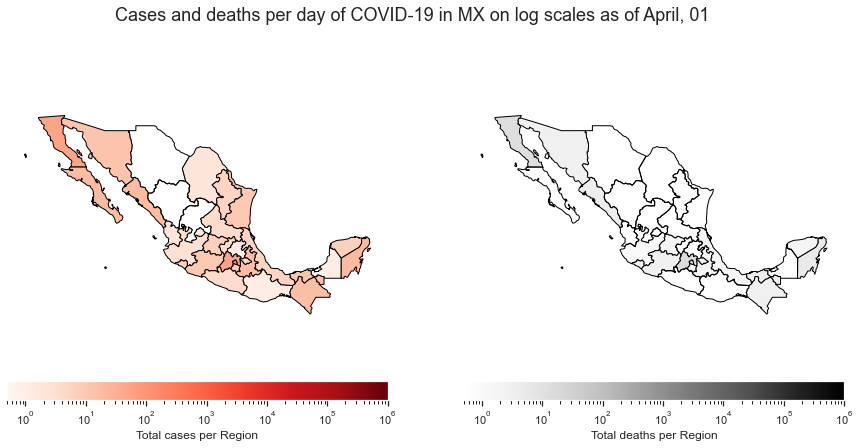

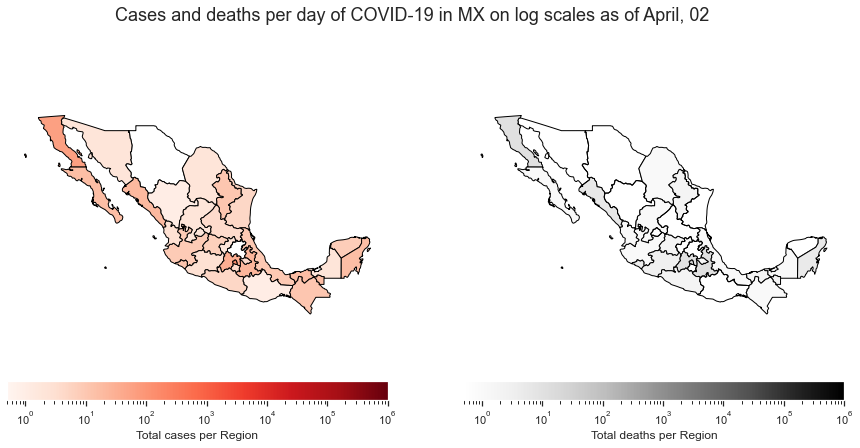

In [22]:
#first loop specifies the month. Second loop is the day. 
title = 'Cases and deaths per day of COVID-19 in MX on log scales as of '
labels = ['Total cases per Region', 'Total deaths per Region' ] 
path = 'map_images/COVID-19_MX_'
for i in range (4, 5):
    for ii in range(1,3): 
        data = merge_shape_df(i, ii, df_cumulative , 'FECHA_SINTOMAS',df_geo_states, 'FIPS_ADMIN', 'ENTIDAD_UM')
        visualize_cases(i, ii, data, ['RESULTADO', 'DEF'], ['Reds', 'Greys'], title, labels, path)
        